## CIFAR-10 Dataset

Contains images of dogs, cats, automobiles, deer etc.

## Importing Libraries

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Getting the data

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['train', 'test']
['truck', 'horse', 'bird', 'automobile', 'dog', 'cat', 'deer', 'ship', 'airplane', 'frog']


## Creating PyTorch data


For folder structures like these, we can use `ImageFolder` class from `torchvision.dataset` to create a PyTorch dataset. We also apply transforms.

Few points - 
* **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once we have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
* **Channel-wise data normalization**: Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
Basically, since the pixel values will be used to compute loss, then gradients, it means if pixels are in the higher range, they'll have a higher effect on the loss, thus a higher effect on gradients.

  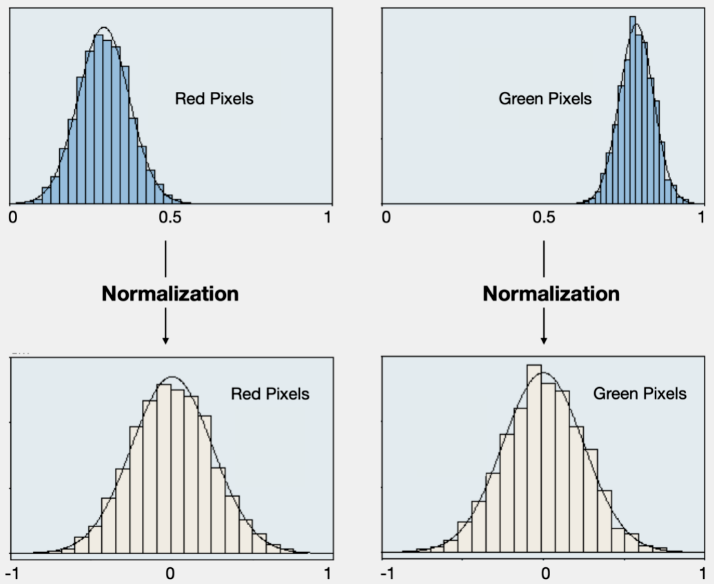

  We'll normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1.

* **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. 

In [3]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),  # padding-> add 4px to each side, then drop the image to 32px. Reflect mode means padding will have mirror image.
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])   # when we train using normalized data, we need to validate/test using normalized data too(model doesn't understand unnormalized data)

In [4]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [5]:
print(f'Size fo dataset: {len(train_ds)}')
img, label = train_ds[0]
print(f'Image size: {img.shape}, Label: {label}\n')
print(f'Image Tensor: {img}\n')
print(f'Classes: {train_ds.classes}')

Size fo dataset: 50000
Image size: torch.Size([3, 32, 32]), Label: 0

Image Tensor: tensor([[[1.7581, 1.7968, 1.8162,  ..., 1.6612, 1.6805, 1.7193],
         [1.8356, 1.8744, 1.9132,  ..., 1.6999, 1.7387, 1.7775],
         [1.9907, 2.0489, 2.1070,  ..., 1.7581, 1.7968, 1.8162],
         ...,
         [2.0876, 1.9132, 1.6418,  ..., 1.7581, 1.7775, 1.7581],
         [2.1845, 2.0295, 1.7775,  ..., 1.7775, 1.7581, 1.5642],
         [2.2427, 2.1458, 1.9132,  ..., 1.6418, 1.3316, 0.6919]],

        [[1.8298, 1.8888, 1.9085,  ..., 1.7708, 1.7904, 1.8298],
         [1.9085, 1.9478, 1.9871,  ..., 1.8101, 1.8495, 1.8888],
         [2.0855, 2.1248, 2.1838,  ..., 1.8691, 1.9085, 1.9281],
         ...,
         [2.1445, 1.9675, 1.7118,  ..., 1.8101, 1.8298, 1.8495],
         [2.2428, 2.1051, 1.8495,  ..., 1.8298, 1.8298, 1.6528],
         [2.3018, 2.2035, 1.9871,  ..., 1.6921, 1.3971, 0.7678]],

        [[1.9148, 1.9538, 1.9928,  ..., 1.8367, 1.8758, 1.9343],
         [2.0319, 2.0709, 2.1099,  ...,

Above we see that each sample element is in the `dataset` is a tuple containing image and its label.

Image is a torch tensor(we already did the transformation above) has 3 color channels, and is 32 x 32 px.

The labels are stored in `dataset.classes` and are accessed by their index

In [6]:
batch_size = 400

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,   # uses all the cores of the GPU/CPU. A little complex, check out documentation.
                      pin_memory=True)   # for each batch keeps a block of memory allocated(use when in each batch the images are going to be of same size, and each batch will take up exact same size)

valid_dl = DataLoader(valid_ds, 
                    batch_size*2,    # for validation we'll not compute gradients, so we'll need half the memory. Therefore we can double the batch size.
                    num_workers=2, 
                    pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range `(0,1)`.

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

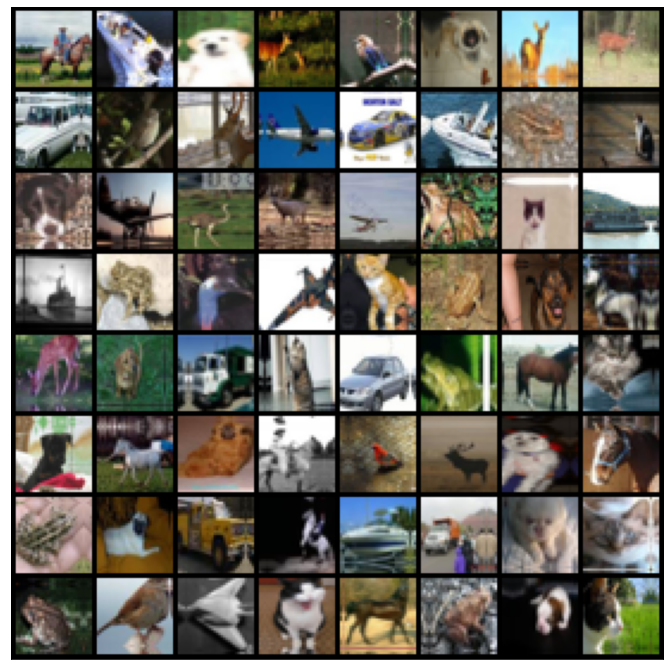

In [8]:
show_batch(train_dl)

## Using a GPU

#### Defing functions
To use GPU we define a few reusable functions that'll help move models & data to CUDA.

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)    # non-blocking indicates that the tensor will be moved to the GPU in a background thread

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

### Moving data to GPU

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

#### Residual Blocks
These add the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

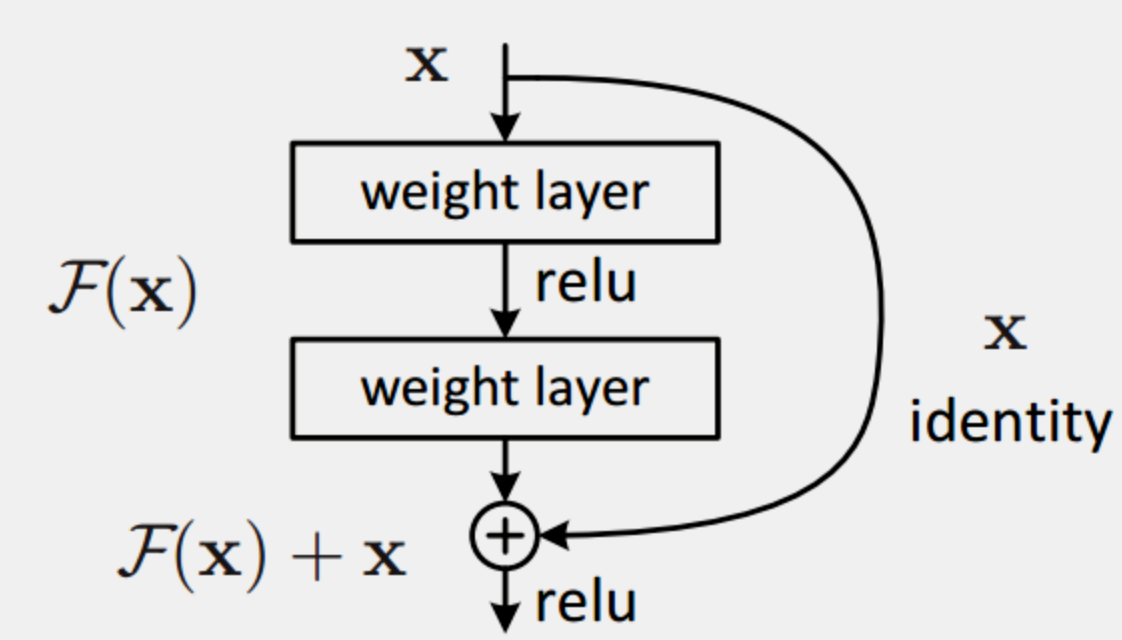

Why we do it? Without the Residual block, the conv nets are responsible for transforming the input into the output. With Residual block, the conv layers are responsible for calculating the difference between the input and the output.
This way the weights can learn more powerful features.

Read more: [https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)

Below is an example of a simple residual block (we won't be using this in out model)

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # no. of input channel in first conv should be equal to no. of output channels in the last layer, otherwise at the end 'x' can't be added
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


We see that this network produces output whose shape is same as its input.

#### Batch Normalization

Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. This is like the normalization we did for each channel in the data augmentation step.

After each layer, one of the channel's values may become very large thus affecting the loss or gradients more. Thus by performing **batch normalization** we prevent this.

Read more: [https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

<br>
For this problem we're using ResNet9 architecture. 

![net](https://raw.githubusercontent.com/lambdal/cifar10-fast/master/net.svg)

Read more: [https://myrtle.ai/learn/how-to-train-your-resnet/](https://myrtle.ai/learn/how-to-train-your-resnet/)


We create `ImageClassificationBase` class which contains helper functions for training & validation.

* `traing_step`: We pass a batch of images through the model, get an output (`out`). Then we calculate the loss(`loss`) and return it.

* `validation_step`: We pass a batch of images through the model, get an output (`out`). Then we calculate the loss(`loss`) & accuracy(`acc`) and return it in a dictionary.

* `validation_epoch_end`: Take losses and accuracy from different batches of data(`batch_losses` & `batch_accs`), combine them by taking their mean, and then return a single loss(`epoch_loss`) and single accuracy(`epoch_accs`) for a epoch in a dictionary.

* `epoch_end`: Takes the epoch number and its results and print them out for each epoch.

`accuracy`: Calculates the accuracy of the model. Takes in the output of the model and target labels, and then compares them & calculates the accuracy.

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We see that a block of conv net keeps repeating, which has one convolutional layer, then a batch normalization, and sometimes a max pooling at the end.

We can define this so it can be reusable.

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))   # if pooling=true, add it to layer
    return nn.Sequential(*layers)  

Now we define the the full network

In [15]:
 class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # input: 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)  # output: 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)  # output: 128 x 16 x 16

        # first residual layer  (we'll add output of conv2 & res1)
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))  # output: 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True)  # output: 2456 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)  # output: 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))  # output: 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),  # output: 512 x 1 x 1
                                        nn.Flatten(),  # flattens the image i.e. from 3d to 1d i.e. 512 x 1 x 1 -> 512
                                        nn.Dropout(0.2), # randomly sets 20% of the values from previous output to zero. Only 80% is passed to next layer
                                        nn.Linear(512, num_classes))  # 10
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training & Validation functions

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: Prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: To prevent the gradient from getting very large values. If gradient value becomes larger than a certain value, it'll be reduced down to that certain value. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [17]:
@torch.no_grad()    # for evaluate fn we don't want to compute any gradients
def evaluate(model, val_loader):
    model.eval()       # model should be put into evaluation mode (some layers(batch norm & dropout etc) will be frozen & there'll be no randomization)
    outputs = [model.validation_step(batch) for batch in val_loader]    # validation loss & acc for each batch
    return model.validation_epoch_end(outputs)   # mean of validation loss & acc for each batch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # removes any existing tensor which aren't currently being used from the gpu memory
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()  # model should be put into training mode
        train_losses = []     # losses for each batch in an epoch
        lrs = []    # LR for each batch in an epoch
        for batch in train_loader:    # for each batch in the dataloader
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Gradient descent performed
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))  # gets the current LR and appends it to the list of LR
            sched.step()  # calcs & sets the next LR
        
        # Validation phase
        result = evaluate(model, val_loader)    # validation loss & acc for that epoch
        result['train_loss'] = torch.stack(train_losses).mean().item()    # mean of training loss that we calculated batchwise
        result['lrs'] = lrs    # print epoch no., trainng loss, validation loss & validation acc
        model.epoch_end(epoch, result)
        history.append(result)
    return history    # returns the training history of the model

Before we begin training, let's instantiate the model once again and check how it performs on the validation set with the initial set of parameters.


In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.10528847575187683, 'val_loss': 2.3163552284240723}]

### Hyperparameters

We'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

Read more about optimizers: https://ruder.io/optimizing-gradient-descent/index.html

In [19]:
epochs = 8
max_lr = 0.01    #we increase from lr=0.001 to lr=0.01
grad_clip = 0.1
weight_decay = 1e-4  # loss = CELoss + ( 1e-4 * weights^2 )
opt_func = torch.optim.Adam

## Training the Model

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5052, val_loss: 1.6133, val_acc: 0.5034
Epoch [1], last_lr: 0.00935, train_loss: 1.0990, val_loss: 1.2351, val_acc: 0.6404
Epoch [2], last_lr: 0.00972, train_loss: 0.8420, val_loss: 0.8144, val_acc: 0.7290
Epoch [3], last_lr: 0.00812, train_loss: 0.6555, val_loss: 0.6885, val_acc: 0.7713
Epoch [4], last_lr: 0.00556, train_loss: 0.5113, val_loss: 0.5366, val_acc: 0.8156
Epoch [5], last_lr: 0.00283, train_loss: 0.4089, val_loss: 0.4105, val_acc: 0.8612
Epoch [6], last_lr: 0.00077, train_loss: 0.3026, val_loss: 0.3229, val_acc: 0.8901
Epoch [7], last_lr: 0.00000, train_loss: 0.2290, val_loss: 0.2894, val_acc: 0.9045
CPU times: user 4min 14s, sys: 3min 42s, total: 7min 56s
Wall time: 9min 1s


In [21]:
result = history[-1]
print(f'Accuracy: {result["val_acc"]*100} %')

Accuracy: 90.45192003250122 %


## Plot Accuracy
Plot validation set accuracy

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

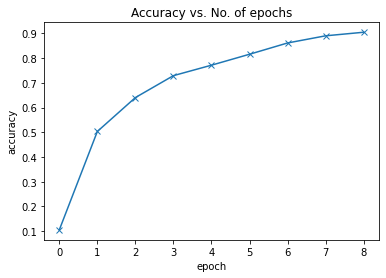

In [23]:
plot_accuracies(history)

## Plot Losses
Plot losses of training & validation set

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

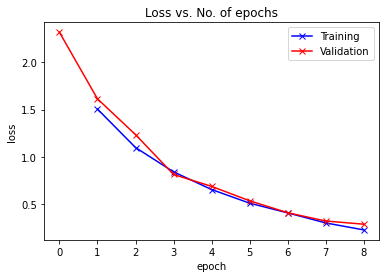

In [25]:
plot_losses(history)

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

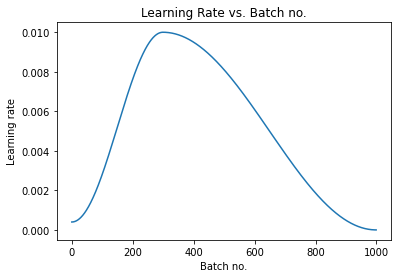

In [27]:
plot_lrs(history)

## Saving the Model

If we save the model(save its weights), we won't have to train it again.

The `state_dict` method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model. 

To load the model weights, we redefine the model with the same structure, and use `load_state_dict` method.

In [28]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [29]:
model2 = to_device(ResNet9(3, 10), device)
model2.load_state_dict(torch.load('cifar10-resnet9.pth'))

<All keys matched successfully>